# Zonal statistics

In [1]:
# Load raster
import rioxarray
burned = rioxarray.open_rasterio('burned.tif')
burned

<xarray.DataArray (band: 1, y: 1131, x: 1207)>
[1365117 values with dtype=int8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.615e+05 5.616e+05 ... 6.097e+05 6.098e+05
  * y            (y) float64 4.035e+06 4.035e+06 4.035e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [2]:
# Load assets vector
import geopandas as gpd
assets = gpd.read_file('assets.gpkg')
assets

,code,type,geometry
0,1,infrastructure,"POLYGON ((27.77240 35.89279, 27.77240 35.89280..."
1,2,built-up,"MULTIPOLYGON (((27.75075 35.87857, 27.75075 35..."


## Align the CRS of the two datasets

In [3]:
burned.rio.crs

CRS.from_epsg(32635)

In [4]:
assets.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
assets = assets.to_crs(burned.rio.crs)

# Rasterizing the vector data

In [6]:
geom = assets[['geometry', 'code']].values.tolist()
geom

[[<POLYGON ((569708.927 3972332.358, 569709.096 3972333.79, 569710.406 3972341...>,
  1],
 [<MULTIPOLYGON (((567767.095 3970740.732, 567767.548 3970741.604, 567772.083 ...>,
  2]]

In [7]:
# The image has 1 band dimension
burned.shape

(1, 1131, 1207)

In [8]:
# A squeeze is needed to make the raster 2D
# Since rasterize function only accept 2D shape
burned.squeeze().shape

(1131, 1207)

In [9]:
burned_squeeze = burned.squeeze()

In [10]:
# Rasterize the vector data.
# transform represents the projection from pixel space to the projected coordinate space. 
# By default, the pixels that are not contained within a polygon in our shapefile will be filled with 0.
from rasterio import features
assets_rasterized = features.rasterize(geom, out_shape=burned_squeeze.shape, transform=burned.rio.transform())

In [11]:
assets_rasterized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

## Create an Xarray.DataArray from the rasterized results

In [12]:
import numpy as np
print(assets_rasterized.shape)
print(np.unique(assets_rasterized))

(1131, 1207)
[0 1 2]


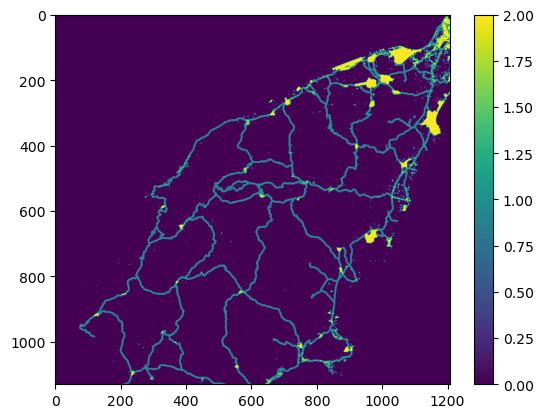

In [13]:
from matplotlib import pyplot as plt
plt.imshow(assets_rasterized)
plt.colorbar()

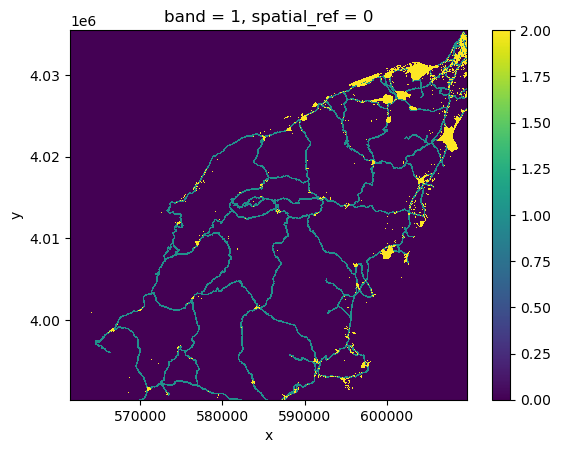

In [14]:
assets_rasterized_xarr = burned_squeeze.copy()
assets_rasterized_xarr.data = assets_rasterized

# visualize zones
assets_rasterized_xarr.plot()

## Perform Zonal Statistcs

In [15]:
from xrspatial import zonal_stats
stats = zonal_stats(assets_rasterized_xarr, burned_squeeze)

In [16]:
stats

,zone,mean,max,min,sum,std,var,count
0,0,0.022570,1.0,0.0,28929.0,0.148528,0.022061,1281749.0
1,1,0.009607,1.0,0.0,568.0,0.097542,0.009514,59125.0
2,2,0.000000,0.0,0.0,0.0,0.000000,0.000000,24243.0


Exercise: Zonal stats over slope zones

Now let's look into the burned areas in relation to slope classes like [Zhai et al., 2023](https://www.mdpi.com/1999-4907/14/4/807) have done. To reproduce their analysis, we will:
1. Reclassify the slope classes into 5 categories  0%–5%, 5%–10%, 10%–15%, 15%–25%, and above 25%, then,
2. Perform the zonal statistics on the above categories.

Hint:
1. Load slope data from 'slope_dask.tif'.
2. The big chellenge will be how to compute the slope zones. Consider:
    - Convert slope data to zones using [`numpy.digitize`](https://numpy.org/doc/stable/reference/generated/numpy.digitize.html).
    - Use [`xarray.apply_ufunc`](https://docs.xarray.dev/en/stable/generated/xarray.apply_ufunc.html) to apply `numpy.digitize` to all the elements in an Xarray. 
4. Note that the slope data and burn index data are in different resolution.

In [17]:
import numpy as np
import xarray as xr

# Load data and remove redundant dimension
# slope = rioxarray.open_rasterio('slope.tif').squeeze()
slope = rioxarray.open_rasterio('slope_dask.tif', masked=True).squeeze()

# Defines the bins for pixel values
# Zone 0 will be values <=0.; Zone 5 will be values >0.25; Zone 6 will be NaN values(>1000)
slope_bins = (0., 0.05, 0.1, 0.15, 0.25, 1000)

slope_zones = xr.apply_ufunc(
    np.digitize,
    slope,
    slope_bins
)

# Reproject burned to slope
# Because slope zones has lower resolution
burned = rioxarray.open_rasterio('burned.tif').squeeze()
burned_match = burned.rio.reproject_match(slope_zones)

# Compute Zonal stats
stats = zonal_stats(slope_zones, burned_match)


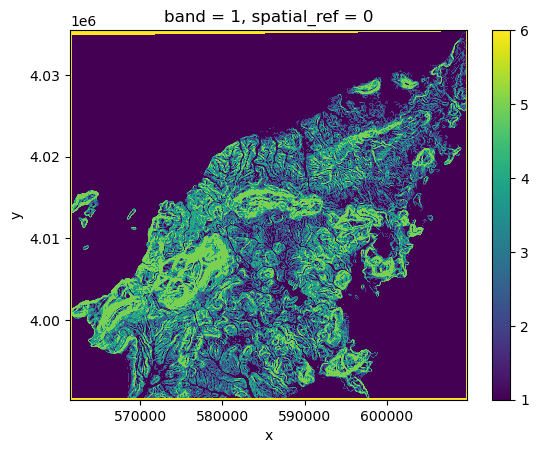

In [18]:
# Visualize slope zones
slope_zones.plot()

In [19]:
stats

,zone,mean,max,min,sum,std,var,count
0,1,0.004118,1.0,0.0,3182.0,0.064037,0.004101,772752.0
1,2,0.051694,1.0,0.0,8023.0,0.221408,0.049021,155203.0
2,3,0.061152,1.0,0.0,7988.0,0.239608,0.057412,130626.0
3,4,0.048064,1.0,0.0,7874.0,0.213901,0.045754,163824.0
4,5,0.019056,1.0,0.0,2220.0,0.136723,0.018693,116496.0
5,6,0.008010,1.0,0.0,210.0,0.089142,0.007946,26216.0
